<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel,  Data Scientist, Ph.D Astrophysics</a> .
</div>

# Colab

In [1]:
%%capture
import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## install modules
    !pip install scikit-plot
    !pip install lrcurve
    !pip install watermark
    !pip install -U scikit-learn

    ## print
    print('Environment: Google Colaboratory.')

## Imports

In [2]:
import time
time_start_notebook = time.time()

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 4)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import os
import sys

# random state
SEED=100
np.random.seed(SEED) # we need this in each cell

# Jupyter notebook settings for pandas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 50)

import scipy
from scipy import stats

# scale and split
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

# deep learning
import tensorflow
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

# model evaluation
import scikitplot
from scikitplot import metrics as skmetrics
import lrcurve
from lrcurve import KerasLearningCurve

# versions
%load_ext watermark
%watermark -a "Bhishan Poudel" -d -v -m
print()
%watermark -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Bhishan Poudel 2020-10-04 

CPython 3.6.9
IPython 5.5.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit

pandas     1.1.2
keras      2.4.3
scipy      1.4.1
matplotlib 3.2.2
tensorflow 2.3.0
scikitplot 0.3.7
seaborn    0.11.0
sklearn    0.23.2
numpy      1.18.5



# Useful Scripts

In [4]:
def show_methods(method, ncols=3):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_methods(list)
     """
    x = [i for i in dir(method) if i[0]!='_' ]
    x = [i for i in x 
         if i not in 'os np pd sys time psycopg2'.split() ]

    return pd.DataFrame(np.array_split(x,ncols)).T.fillna('')

In [5]:
def set_random_seed(seed):
    import os
    import random
    import numpy as np
    import tensorflow as tf
    
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [6]:
def model_evaluation(model_name, desc, ytest, ypreds,df_eval=None,
                     show=True,sort_col='Recall'):
    if df_eval is None:
        df_eval = pd.DataFrame({'Model': [],
                        'Description':[],
                        'Accuracy':[],
                        'Precision':[],
                        'Recall':[],
                        'F1':[],
                        'AUC':[],
                    })

    # model evaluation
    average = 'binary'
    row_eval = [model_name,desc, 
                sklearn.metrics.accuracy_score(ytest, ypreds),
                sklearn.metrics.precision_score(ytest, ypreds, average=average),
                sklearn.metrics.recall_score(ytest, ypreds, average=average),
                sklearn.metrics.f1_score(ytest, ypreds, average=average),
                sklearn.metrics.roc_auc_score(ytest, ypreds),
                ]

    df_eval.loc[len(df_eval)] = row_eval
    df_eval = df_eval.drop_duplicates()
    df_eval = df_eval.sort_values(sort_col)

    if show:
        display(df_eval.style.background_gradient(subset=[sort_col]))

    return df_eval

# Load the data

In [7]:
ifile = "https://github.com/bhishanpdl/Datasets/blob/master/Projects/Fraud_detection/raw/creditcard.csv.zip?raw=true"
# ifile = '../data/raw/creditcard.csv.zip'

df_raw = pd.read_csv(ifile,compression='zip')
print(df_raw.shape)
df_raw.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Data Processing

## Class balance

0    284315
1       492
Name: Class, dtype: int64

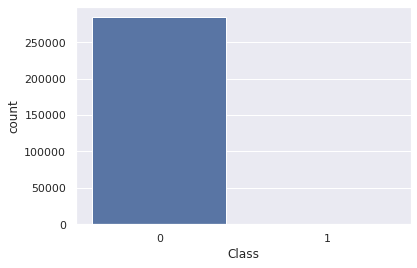

In [11]:
target = 'Class'
display(df_raw[target].value_counts())
sns.countplot(x=df_raw[target])

In [12]:
neg, pos = np.bincount(df_raw['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



## Feature Selection

In [13]:
cols_drop = ['Time']

df = df_raw.drop(cols_drop,axis=1)
df.shape

(284807, 30)

## Log transform

In [14]:
eps=0.001 # 0 => 0.1¢
df['Ammount'] = np.log(df.pop('Amount')+eps)

## Train-validation-test split with stratify

In [15]:
from sklearn.model_selection import train_test_split

target = 'Class'

df_Xtrain_orig,df_Xtest,ser_ytrain_orig,ser_ytest = train_test_split(df.drop([target],axis=1),
                                             df[target],
                                             test_size=0.2,
                                             stratify=df[target],
                                             random_state=SEED)

df_Xtrain,df_Xvalid,ser_ytrain,ser_yvalid = train_test_split(df_Xtrain_orig,
                                             ser_ytrain_orig,
                                             test_size=0.2,
                                             stratify=ser_ytrain_orig,
                                             random_state=SEED)

ytrain = np.array(ser_ytrain)
yvalid = np.array(ser_yvalid)
ytest = np.array(ser_ytest)

df.shape, df_Xtrain.shape, ser_ytrain.shape

((284807, 30), (182276, 29), (182276,))

## Normalize the data

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_Xtrain)

Xtrain = scaler.transform(df_Xtrain)
Xvalid = scaler.transform(df_Xvalid)
Xtest  = scaler.transform(df_Xtest)

# clip the values
Xtrain = np.clip(Xtrain, -5, 5)
Xvalid = np.clip(Xvalid, -5, 5)
Xtest = np.clip(Xtest, -5, 5)

# Modelling: Keras Sequential

## Correct initial bias

In [17]:
neg, pos = np.bincount(df_raw['Class'])
total = neg + pos

initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

## Class weights

In [18]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


# Params and Metrics

In [23]:
n_feats = Xtrain.shape[-1]
class_weight = {0: weight_for_0, 1: weight_for_1}

#============================================================
PARAMS_MODEL = {
    # layer 1
    'L1_units': 16,
    'L1_act': 'relu',
    'L1_dropout': 0.5,

    # optimizer
    'adam_lr': 1e-3,
}

#============================================================
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

#============================================================
PARAMS_FIT = {'epochs': 100,
          'batch_size': 2048,
          'class_weight0': class_weight[0],
          'class_weight1': class_weight[1],
          'patience': 10,
          'shuffle': True,
          }

#============================================================
PARAMS_CLF   = {'class_weight' : class_weight}


#============================================================
# callbacks
cb_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=PARAMS_FIT['patience'],
    mode='max',
    restore_best_weights=True)

#cb_checkpt = keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")
cb_lr = lrcurve.KerasLearningCurve()
callbacks = [cb_early, cb_lr]

# Build the Model

In [46]:
def one_layer(metrics=METRICS, output_bias=None,n_feats=n_feats):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = keras.Sequential([
        # layer 1
        keras.layers.Dense(PARAMS_MODEL['L1_units'],
                           activation=PARAMS_MODEL['L1_act'],
                           input_shape=(n_feats,)),

        keras.layers.Dropout(PARAMS_MODEL['L1_dropout']),

        # last layer is dense 1 with activation sigmoid
        keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=PARAMS_MODEL['adam_lr']),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

model = make_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 16)                480       
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


## Fit the model using KerasClassifier

In [22]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [65]:
model = KerasClassifier(one_layer,
                    batch_size=PARAMS_FIT['batch_size'],
                    epochs=PARAMS_FIT['epochs'],
                    class_weight=class_weight,
                    verbose=0)

In [67]:
# model.fit accepts all sequential model.fit parameters

## Stratified Cross Validation

In [31]:
%%time

# note
set_random_seed(SEED)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

scores = []
for idx_tr, idx_vd in skf.split(Xtrain, ytrain):
    X_cv, y_cv = Xtrain[idx_tr], ytrain[idx_tr]
    model.fit(X_cv, y_cv)
    scores.append(model.score(X_cv, y_cv))

CPU times: user 7min 10s, sys: 27.5 s, total: 7min 37s
Wall time: 4min 18s


In [54]:
print(scores)

[0.9883418083190918, 0.9879372715950012, 0.9879372715950012, 0.9881910085678101, 0.9894047975540161]


In [55]:
show_methods(model)

,0,1,2
0,build_fn,get_params,predict_proba
1,check_params,model,score
2,classes_,n_classes_,set_params
3,filter_sk_params,predict,sk_params
4,fit,,


In [60]:
# clf.get_params()

{'batch_size': 2048,
 'build_fn': <function __main__.make_model>,
 'class_weight': {0: 0.5008652375006595, 1: 289.43800813008136},
 'epochs': 100,
 'verbose': 0}

In [64]:
# clf.sk_params

In [75]:
# # last validation scores
# clf.fit(X_cv, y_cv)
# ypreds = clf.predict(X_cv).flatten()

# df_tmp = model_evaluation("keras", '', y_cv, ypreds,df_eval=None)
# score = clf.score(X_cv,y_cv)

# # I found that score is accuracy score

# Model Evaluation

In [39]:
%%time
model.fit(Xtrain, ytrain)

CPU times: user 1min 46s, sys: 6.69 s, total: 1min 53s
Wall time: 1min 2s


## Confusion Matrix

In [40]:
from sklearn import metrics as skmetrics

In [41]:
yprobs = model.predict_proba(Xtest)
yprobs[:5]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[1],
       [0],
       [0],
       [0],
       [0]])

In [53]:
ypreds = (yprobs.flatten()>0.5).astype(np.int8)
ypreds[:5]

array([1, 1, 1, 0, 0], dtype=int8)

In [43]:
skmetrics.confusion_matrix(ytest, ypreds)

array([[56190,   674],
       [   13,    85]])

In [44]:
from scikitplot import metrics as skpmetrics

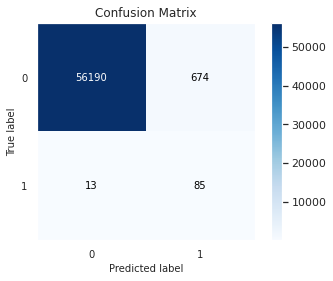

In [45]:
skpmetrics.plot_confusion_matrix(ytest,ypreds)

In [47]:
def plot_cm(labels, predictions, p=0.5):
  cm = sklearn.metrics.confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Legitimate Transactions Detected (True Negatives):  56190
Legitimate Transactions Incorrectly Detected (False Positives):  674
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  85
Total Fraudulent Transactions:  98


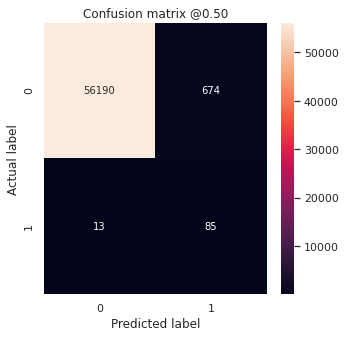

In [48]:
plot_cm(ytest,ypreds)

<div class="alert alert-block alert-success">
<b>NOTE:</b> 
confusion matrix is
TN FP
FN TP

Here, diagonal values are True Negatives and True Postives, ideally we want non-diagonal elements to be zero. But we some mis-predictions.

The top right value is False Positive.
They are not frauds but our model predict them as frauds.
Company needs to send them email to verify if the transaction
is legal or not and if we send too many emails it might annoy the customers.

The bottom left value is False Negative.
They are the actual frauds classified as normal persons by the model. This cost the company money and have to deal with fraudulent cases. This is much more undesirable than False Posivites.

In real life, the trade off much be chosen much carefully so as not to bug too many customers as well as not to miss the frauds.
</div>

## Accuracy Recall Scores

In [49]:
desc = "simple model"
yprobs = model.predict(Xtest)

ypreds = ypreds.ravel()
ypreds = (yprobs.flatten()>0.5).astype(np.int8)

df_eval = model_evaluation("keras", desc, ytest, ypreds,df_eval=None)

,Model,Description,Accuracy,Precision,Recall,F1,AUC
0,keras,simple model,0.752502,0.004039,0.581633,0.008021,0.667214


## Training History Plots

In [50]:
matplotlib.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [51]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                    color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [52]:
plot_metrics(history)

NameError: ignored

<div class="alert alert-block alert-danger">
<b>WARNING:</b> 
Here Validation data has more AUC than training, this is because dropout layer is not active when evaluating the model.
</div>

# Time Taken

In [ ]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))